In [ ]:
class Ad:
    def __init__(self, id, impressions=0, clicks=0):
        self.id = str(id)
        self.impressions = impressions
        self.clicks = clicks

    def ctr(self):
        """Gets the CTR (Click-through rate) for this ad.
        Returns:
            float: Returns the CTR (between 0 and 1)
        """
        return 0.0 if self.impressions == 0 else float(self.clicks / self.impressions)

    def __repr__(self):
        return "({0}/{1})".format(self.clicks, self.impressions)
    
    def __str__(self):
        return "Ad: {0}, CTR: {1:.4f}".format(self.id, self.ctr())

    def __eq__(self, other) : 
        return self.id == other.id and self.impressions == other.impressions and self.clicks == other.clicks

In [ ]:
from typing import Optional
import gym
from gym import logger, spaces
from gym.utils import seeding

import numpy as np
from numpy.random.mtrand import RandomState

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['toolbar'] = 'None'

class AdServerEnv(gym.Env):
    metadata = {
        'render.modes': ['human']
    }

    def __init__(self, num_ads, time_series_frequency, reward_policy=None):        
        self.time_series_frequency = time_series_frequency        
        self.num_ads = num_ads
        self.reward_policy = reward_policy
        self.click_probabilities = None

        # Initial state (can be reset later)
        ads = [Ad(i) for i in range(num_ads)]
        clicks = 0
        impressions = 0
        self.state = (ads, impressions, clicks)
        self.ctr_time_series = []

        # Environment OpenAI metadata
        self.reward_range = (0, 1)
        self.action_space = spaces.Discrete(num_ads) # index of the selected ad
        self.observation_space = spaces.Box(low=0.0, high=np.inf, shape=(2, num_ads), dtype=np.float) # clicks and impressions, for each ad

    def step(self, action):
        ads, impressions, clicks = self.state

        # Update clicks (if any)
        reward = self.draw_click(action)
        if reward == 1:
            clicks += 1
            ads[action].clicks += 1

        # Update impressions
        ads[action].impressions += 1
        impressions += 1

        # print("State", self.state)
        # Update the ctr time series (for rendering)
        if impressions % self.time_series_frequency == 0:
            ctr = 0.0 if impressions == 0 else float(clicks / impressions)
            self.ctr_time_series.append(ctr)
            # print("test")

        self.state = (ads, impressions, clicks)

        return self.state, reward, False, {}

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        self.scenario_name = "DQNAgent"
        ads = [Ad(i) for i in range(self.num_ads)]
        clicks = 0
        impressions = 0
        self.state = (ads, impressions, clicks)
        self.ctr_time_series = []
        return self.state

    def render(self, mode='human', freeze=False, output_file=None): # pragma: no cover
        if mode != 'human':
            raise NotImplementedError

        ads, impressions, clicks = self.state
        ctr = 0.0 if impressions == 0 else float(clicks / impressions)

        logger.info('Scenario: {}, Impressions: {}, CTR: {}, Ads: {}'.format(self.scenario_name, impressions, ctr, ads))

        fig = plt.figure(num=self.scenario_name,figsize=(9, 6))
        grid_size = (5, 2)
        
        # Plot CTR time series 
        plt.subplot2grid(grid_size, (0, 0), rowspan=2, colspan=2)
        x = [i for i, _ in enumerate(self.ctr_time_series)]
        y = self.ctr_time_series        
        axes = plt.gca()
        axes.set_ylim([0,None])
        plt.xticks(x, [(i + 1) * self.time_series_frequency for i, _ in enumerate(x)])
        plt.ylabel("CTR")
        plt.xlabel("Impressions")
        plt.plot(x, y, marker='o')
        for x,y in zip(x,y):
            plt.annotate("{:.2f}".format(y), (x,y), textcoords="offset points", xytext=(0,10), ha='center')
        
        # Plot impressions
        plt.subplot2grid(grid_size, (2, 0), rowspan=3, colspan=1)
        x = [ad.id for ad in ads]
        impressions = [ad.impressions for ad in ads]
        x_pos = [i for i, _ in enumerate(x)]
        plt.barh(x_pos, impressions)
        plt.ylabel("Ads")
        plt.xlabel("Impressions")
        plt.yticks(x_pos, x)

        # Plot CTRs and probabilities
        plt.subplot2grid(grid_size, (2, 1), rowspan=3, colspan=1)
        x = [ad.id for ad in ads]
        y = [ad.ctr() for ad in ads]
        y_2 = self.click_probabilities
        x_pos = [i for i, _ in enumerate(x)]
        x_pos_2 = [i + 0.4 for i, _ in enumerate(x)]
        plt.ylabel("Ads")
        plt.xlabel("")
        plt.yticks(x_pos, x)        
        plt.barh(x_pos, y, 0.4, label='Actual CTR')
        plt.barh(x_pos_2, y_2, 0.4, label='Probability')
        plt.legend(loc='upper right')
                
        plt.tight_layout()

        if output_file is not None:
            fig.savefig(output_file)

        if freeze:
            # Keep the plot window open
            # https://stackoverflow.com/questions/13975756/keep-a-figure-on-hold-after-running-a-script
            if matplotlib.is_interactive(): 
                plt.ioff()
            plt.show(block=True)
        else:
            plt.show(block=False)
            plt.pause(0.001)                 

    def draw_click(self, action):
        if self.reward_policy is not None:
            return self.reward_policy(action)

        if self.click_probabilities is None:
            self.click_probabilities = [self.np_random.uniform() * 0.5 for i in range(self.num_ads)]

        return 1 if self.np_random.uniform() <= self.click_probabilities[action] else 0

    def close(self):
        plt.close()

In [ ]:
## New Environment


In [1]:
import gym, gym_auction_emulator

In [2]:
env = gym.make('AuctionEmulator-v0')

In [3]:
import argparse
import sys
import time

import gym
from gym import wrappers, logger


class RandomAgent(object):

    def __init__(self, action_space):
        self.name = "Random Agent"
        self.action_space = action_space

    def act(self, observation, reward, done):
        return self.action_space.sample()

if __name__ == '__main__':
    # Setup the environment
    env = gym.make('AuctionEmulator-v0')

    # Setup the agent
    agent = RandomAgent(env.action_space)

    # Simulation loop
    reward = 0
    done = False
    observation, done = env.reset() #seed=0, options={"scenario_name": agent.name})
    action = agent.act(observation, reward, done)
    observation, reward, done, _ = env.step(action)
    print(observation)   
    env.close()

here


C:\ProgramData\Anaconda3\envs\RL\lib\site-packages\gym\utils\passive_env_checker.py:175: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  "Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator."
C:\ProgramData\Anaconda3\envs\RL\lib\site-packages\gym\utils\passive_env_checker.py:188: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  "Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information."


AssertionError: The obs returned by the `reset()` method observation keys is not same as the observation space keys, obs keys: ['click', 'pCTR', 'weekday', 'hour', 'min', 'bidid', 'timestamp', 'logtype', 'ipinyouid', 'useragent', 'IP', 'region', 'city', 'adexchange', 'domain', 'url', 'urlid', 'slotid', 'slotwidth', 'slotheight', 'slotvisibility', 'slotformat', 'slotprice', 'creative', 'bidprice', 'payprice', 'keypage', 'advertiser', 'usertag'], space keys: ['agent', 'target']

<ipython-input-2-62c918d139d1>:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.observation_space = spaces.Box(low=0.0, high=np.inf, shape=(2, num_ads), dtype=np.float) # clicks and impressions, for each ad


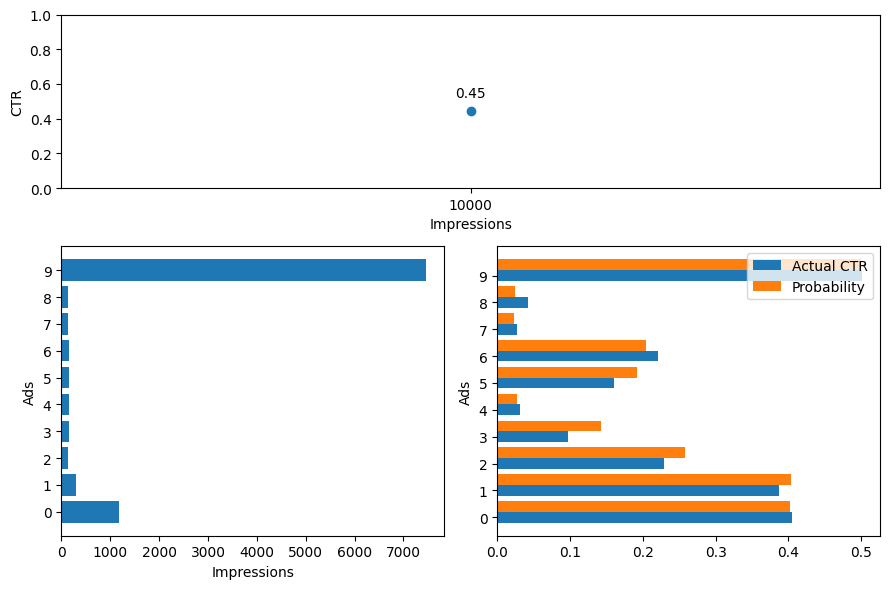

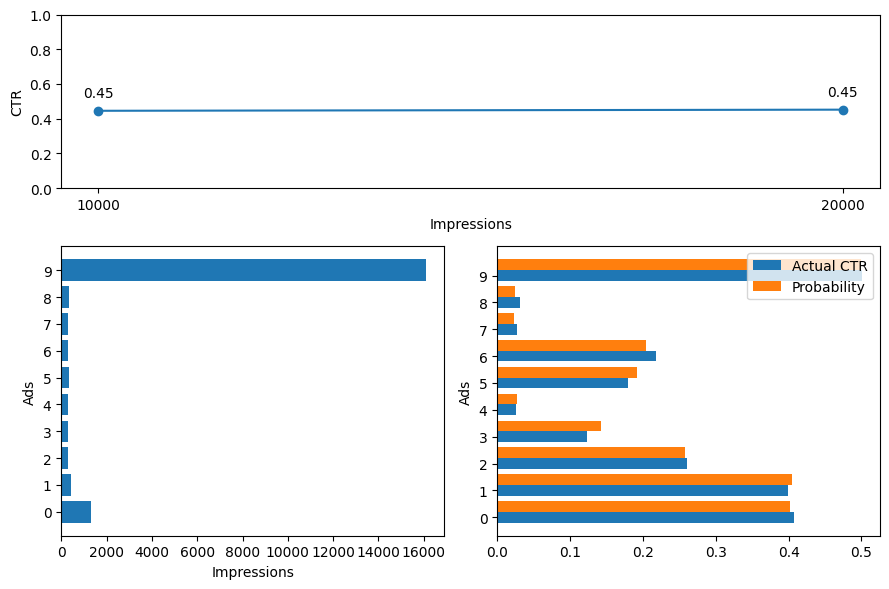

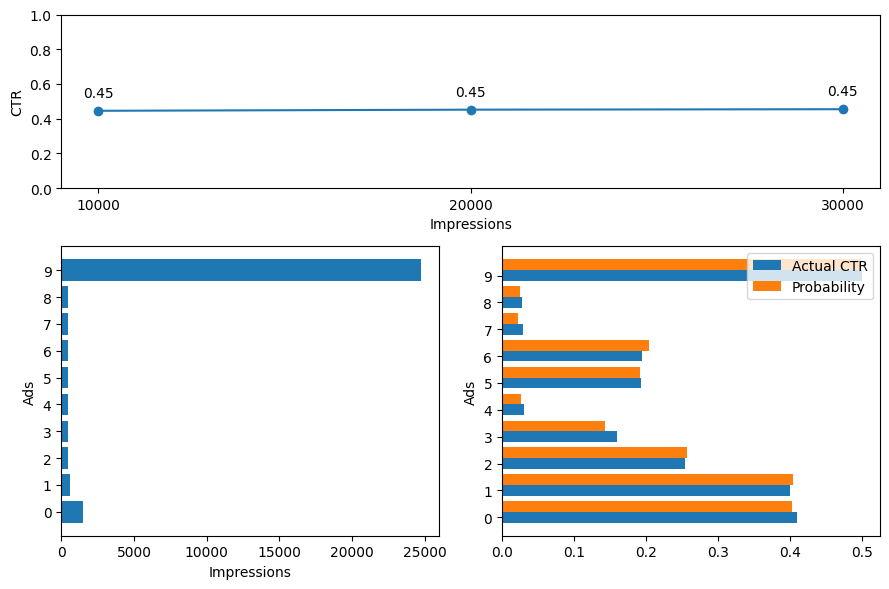

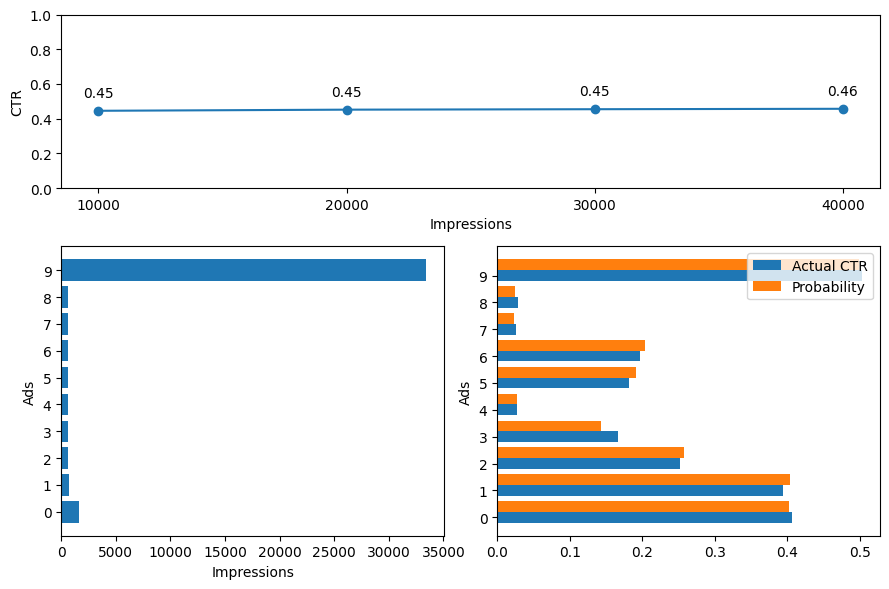

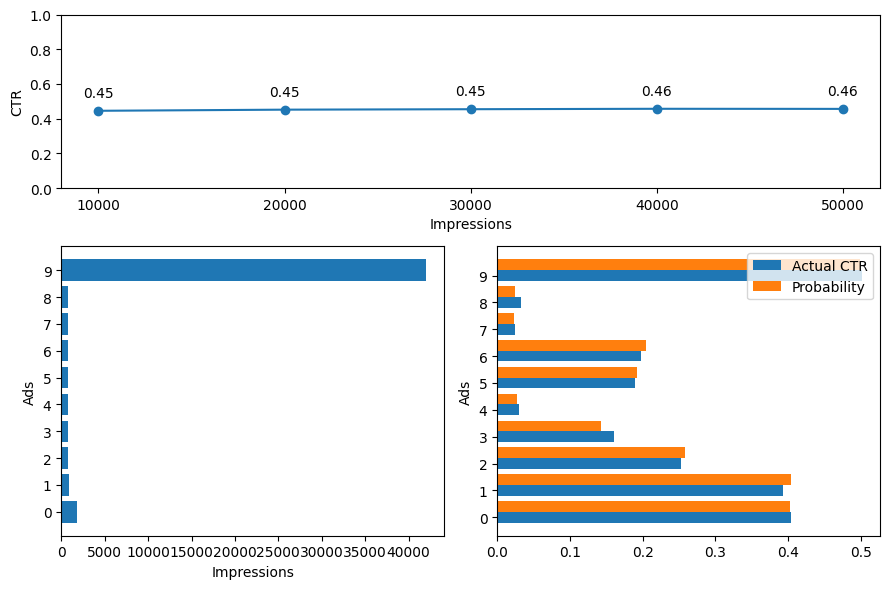

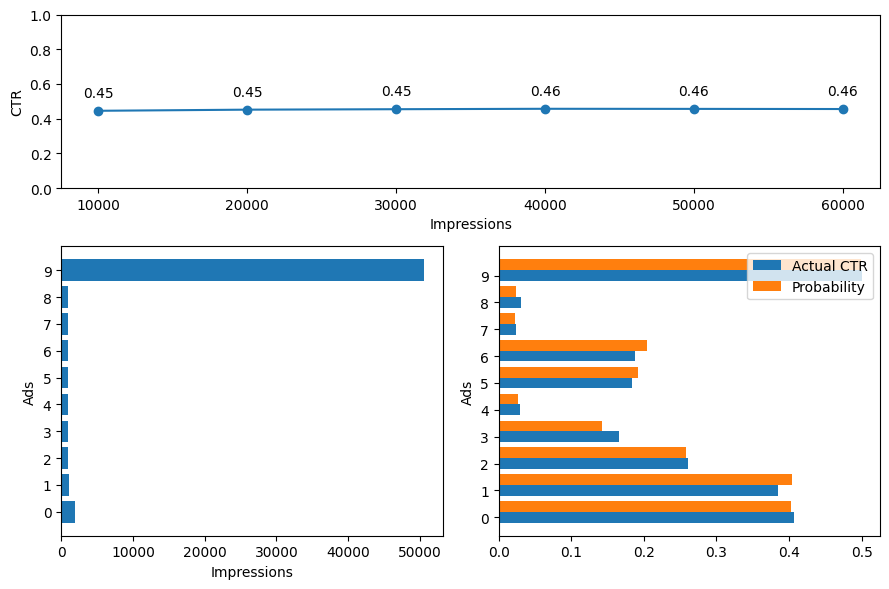

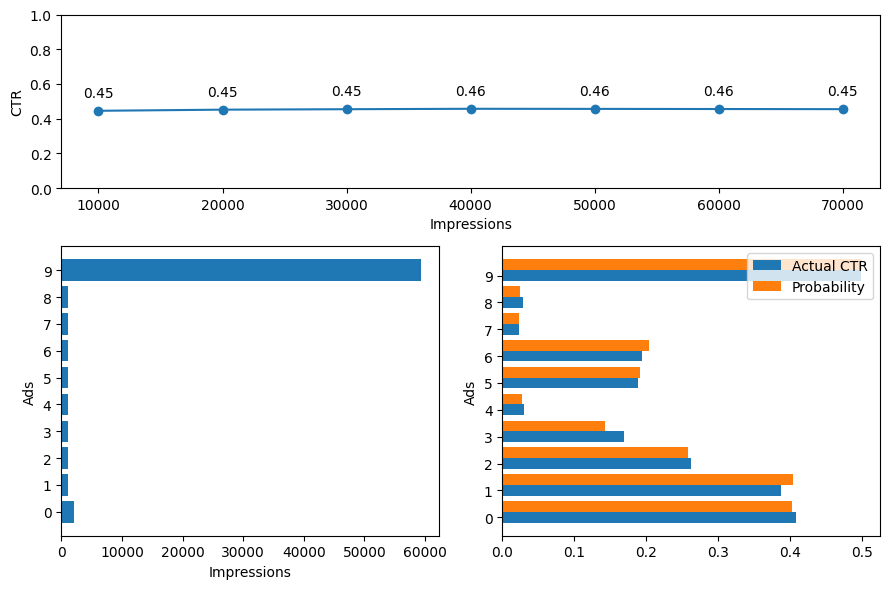

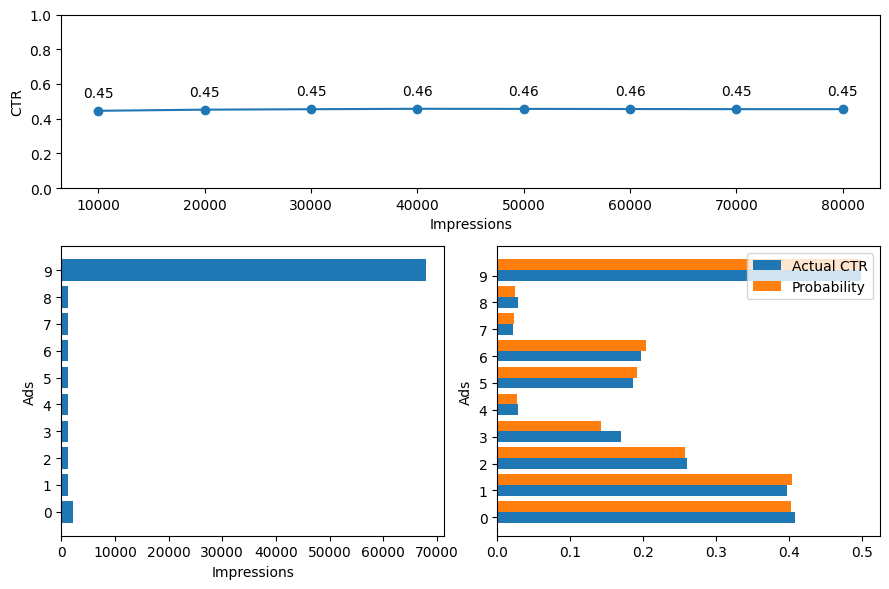

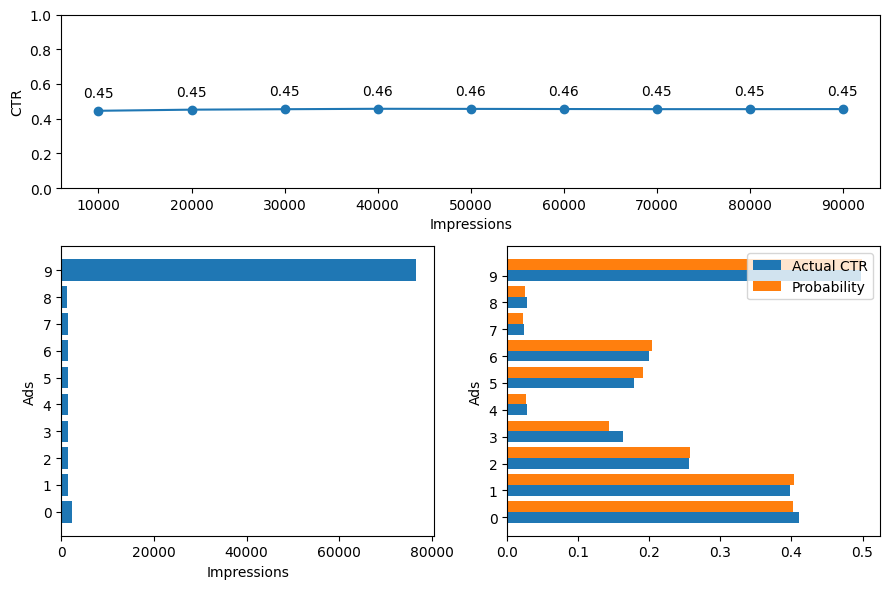

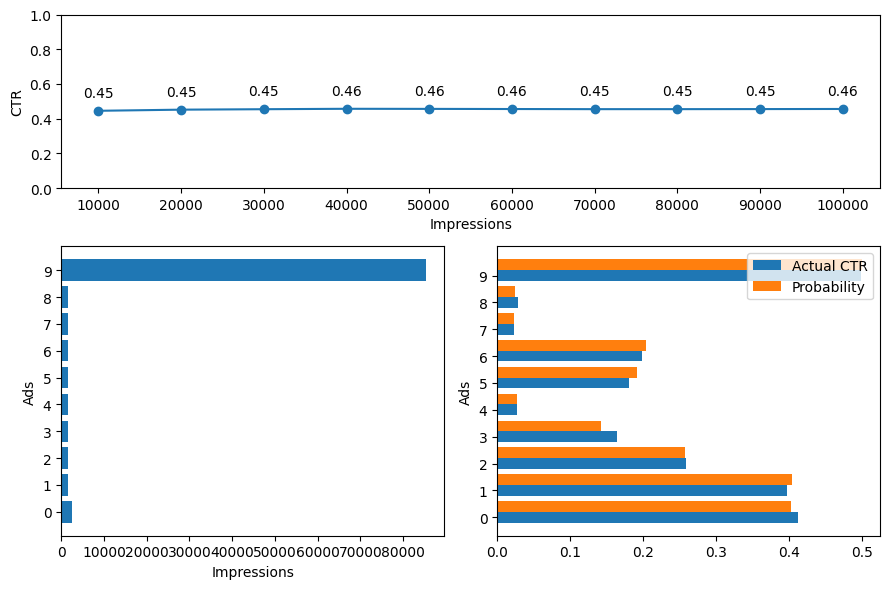

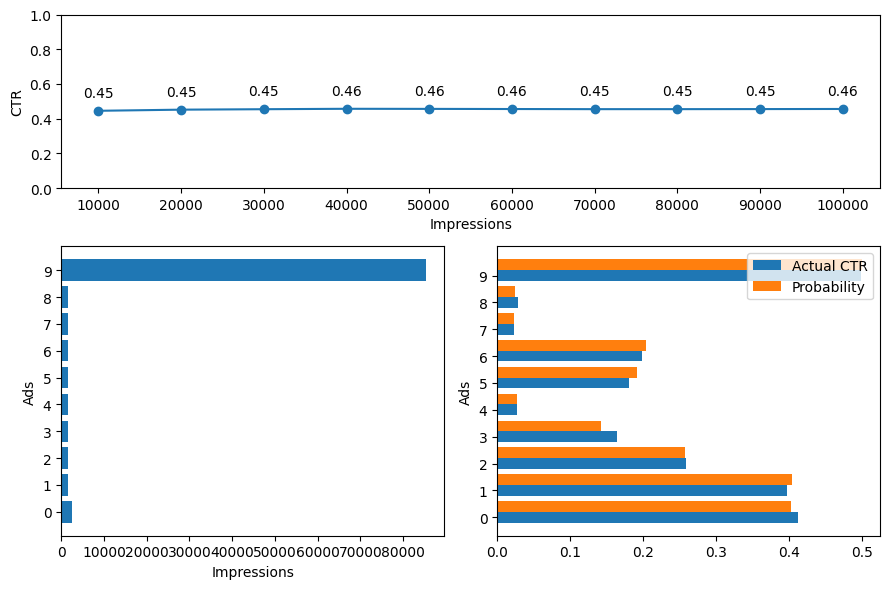

In [ ]:
class EpsilonGreedyAgent(object):
    def __init__(self, seed, epsilon):
        self.name = "epsilon-Greedy Agent"
        self.np_random = RandomState(seed)
        self.epsilon = epsilon

    def act(self, observation, reward, done):
        ads, _, _ = observation

        if np.random.uniform() < self.epsilon:
            # Exploration: choose randomly
            ad_index = self.np_random.randint(0, len(ads))
        else:
            # Exploitation: choose the ad with the highest CTR so far
            ad_index = np.argmax([ad.ctr() for ad in ads])

        return ad_index

episodes = 100000
seed=5
time_series_frequency = episodes // 10

# Setup the environment
env = AdServerEnv(10,time_series_frequency)

# Setup the agent
agent = EpsilonGreedyAgent(seed, 0.15)

# Simulation loop
reward = 0
done = False
observation = env.reset(seed=seed, options={"scenario_name": agent.name})
for i in range(episodes):
    # Action/Feedback
    ad_index = agent.act(observation, reward, done)
    observation, reward, done, _ = env.step(ad_index)
    
    # Render the current state
    observedImpressions = observation[1]
    if observedImpressions % time_series_frequency == 0: 
        env.render()
    
    if done:
        break

# Render the final state and keep the plot window open
env.render(freeze=True, output_file="test")

env.close()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque

# DQN Model
class DQN(nn.Module):
    def __init__(self, n_states, n_actions, n_hidden=128):
      super(DQN, self).__init__()
      self.fc1 = nn.Linear(n_states, n_hidden)
      self.fc2 = nn.Linear(n_hidden, n_hidden)
      self.fc3 = nn.Linear(n_hidden, n_actions)

    def forward(self, x):
      x = torch.relu(self.fc1(x))
      x = torch.relu(self.fc2(x))
      x = self.fc3(x)
      return x

# DQN Agent
class DQNAgent:
    def __init__(self, env, buffer_size=10000, batch_size=128, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.999, lr=0.001):
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.n_states = env.observation_space.shape[1] * env.observation_space.shape[0]
      self.n_actions = env.action_space.n
      self.buffer_size = buffer_size
      self.batch_size = batch_size
      self.gamma = gamma
      self.epsilon = epsilon
      self.epsilon_min = epsilon_min
      self.epsilon_decay = epsilon_decay
      self.model = DQN(self.n_states, self.n_actions).to(self.device)
      self.target_model = DQN(self.n_states, self.n_actions).to(self.device)
      self.target_model.load_state_dict(self.model.state_dict())
      self.buffer = deque(maxlen=buffer_size)
      self.loss_fn = nn.MSELoss()
      self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
      self.env = env

    def state_to_input(self, state):
      state = [(ad.impressions, ad.clicks) for ad in state[0]]
      state = np.array(state).flatten()
      return torch.FloatTensor(state).to(self.device)


    def act(self, state):
      if np.random.rand() < self.epsilon:
          return self.env.action_space.sample()
      else:
          state = self.state_to_input(state)
          q_values = self.model(state)
          return q_values.argmax().item()

    def remember(self, state, action, reward, next_state, done):
      self.buffer.append((self.state_to_input(state), action, reward, self.state_to_input(next_state), done))

    def replay(self):
      if len(self.buffer) < self.batch_size:
          return
      batch = random.sample(self.buffer, self.batch_size)
      state_batch = torch.stack([transition[0] for transition in batch])
      action_batch = torch.LongTensor([transition[1] for transition in batch]).unsqueeze(1).to(self.device)
      reward_batch = torch.FloatTensor([transition[2] for transition in batch]).unsqueeze(1).to(self.device)
      next_state_batch = torch.stack([transition[3] for transition in batch])
      done_batch = torch.FloatTensor([transition[4] for transition in batch]).unsqueeze(1).to(self.device)
      q_values = self.model(state_batch).gather(1, action_batch)
      next_q_values = self.target_model(next_state_batch).max(1)[0].unsqueeze(1)
      expected_q_values = reward_batch + (1 - done_batch) * self.gamma * next_q_values
      loss = self.loss_fn(q_values, expected_q_values)
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

    def target_train(self):
      self.target_model.load_state_dict(self.model.state_dict())

    def update_epsilon(self):
      self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-2-62c918d139d1>:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.observation_space = spaces.Box(low=0.0, high=np.inf, shape=(2, num_ads), dtype=np.float) # clicks and impressions, for each ad


Episode: 0 Total Reward: 130 
Episode 0/1000 | Mean score: 2.90 | Epsilon: 0.95


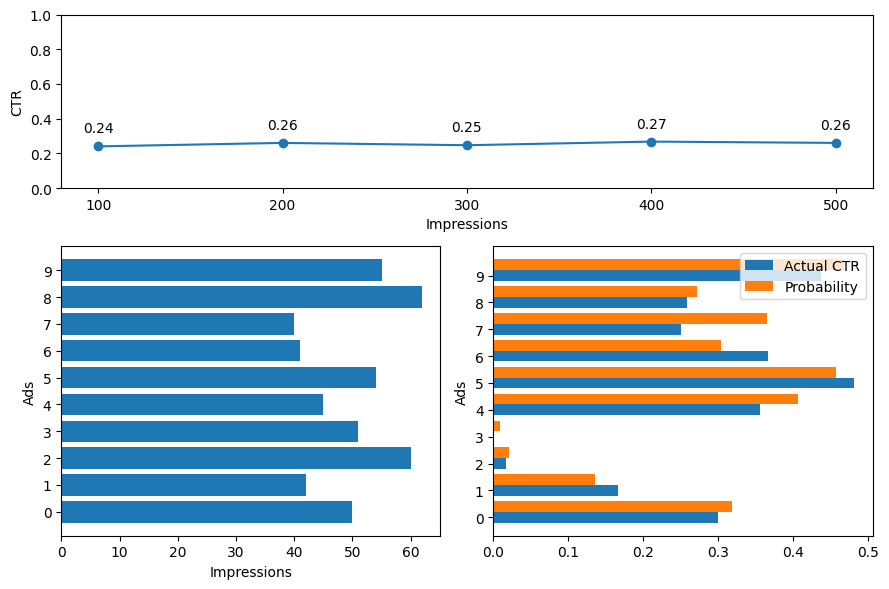

Episode: 50 Total Reward: 138 
Episode 50/1000 | Mean score: 3.00 | Epsilon: 0.08


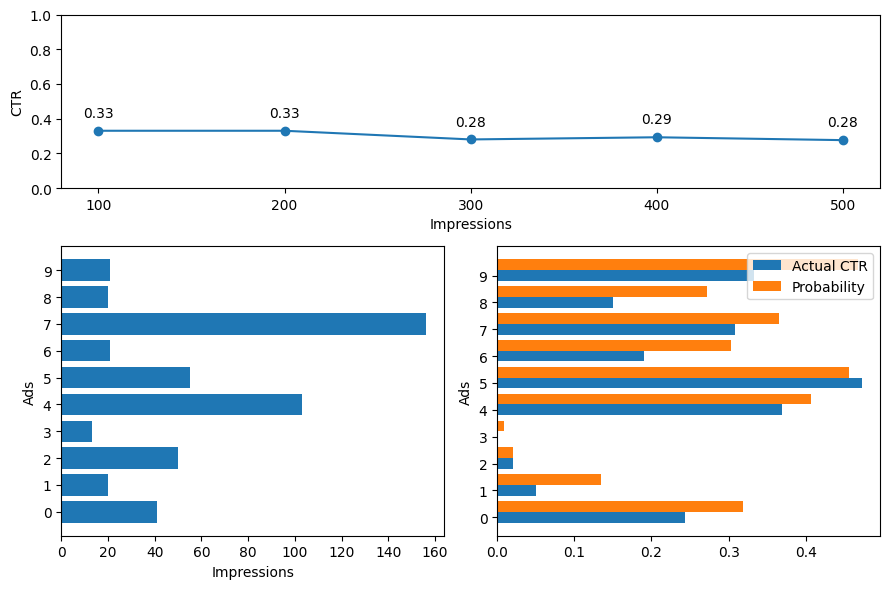

Episode: 100 Total Reward: 146 
Episode 100/1000 | Mean score: 3.22 | Epsilon: 0.03


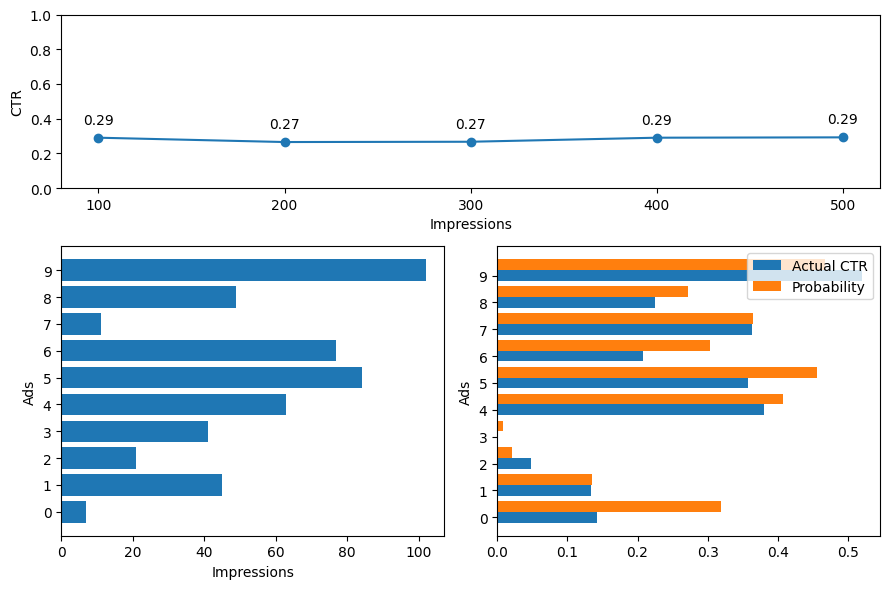

Episode: 150 Total Reward: 151 
Episode 150/1000 | Mean score: 3.42 | Epsilon: 0.03


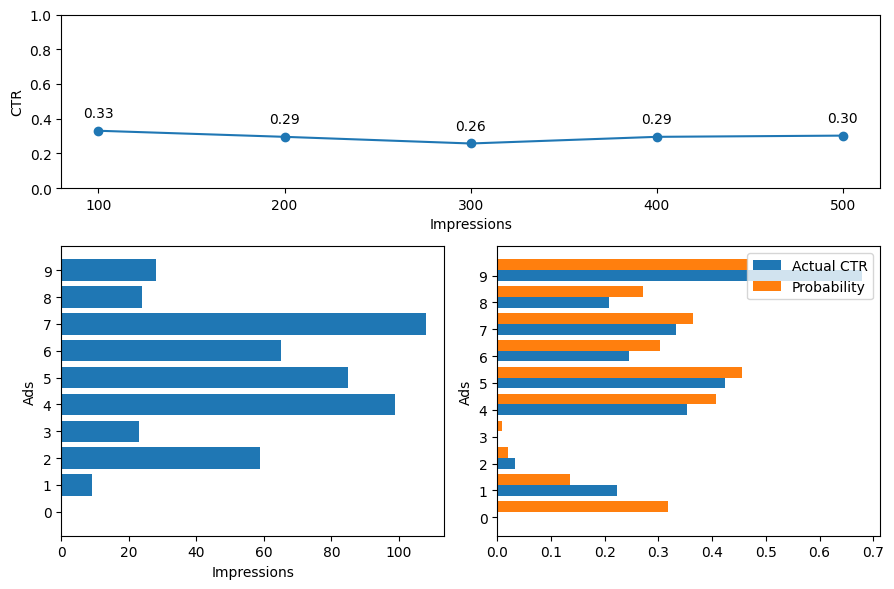

Episode: 200 Total Reward: 136 
Episode 200/1000 | Mean score: 2.98 | Epsilon: 0.03


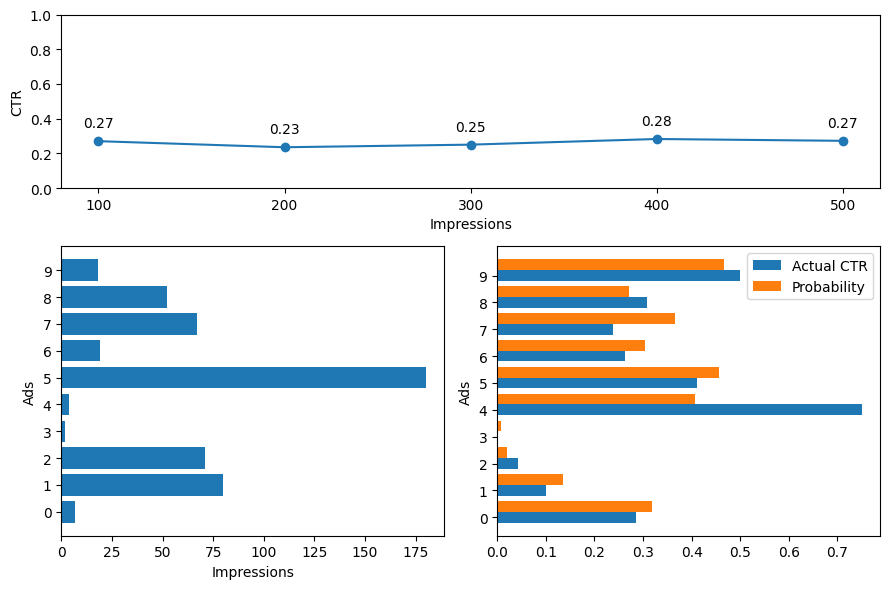

Episode: 250 Total Reward: 161 
Episode 250/1000 | Mean score: 3.52 | Epsilon: 0.03


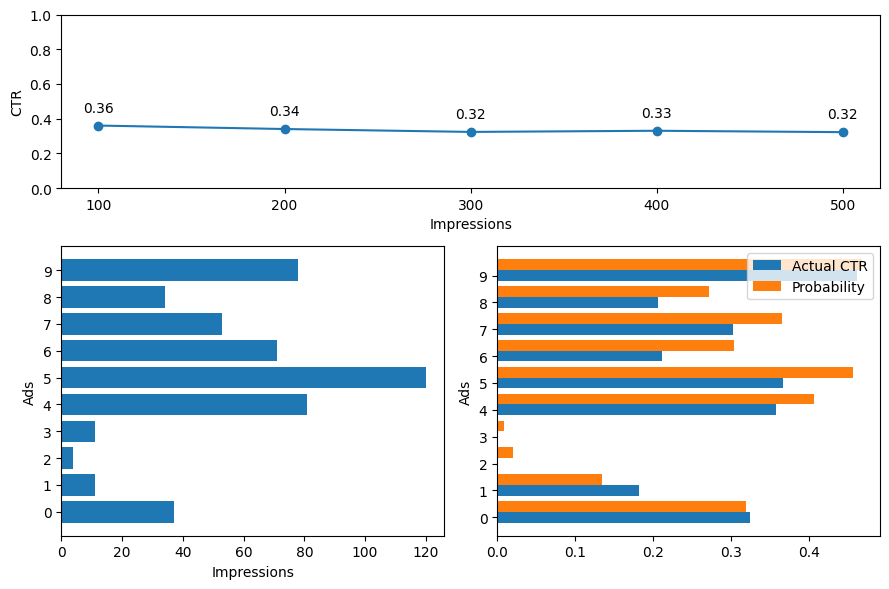

Episode: 300 Total Reward: 102 
Episode 300/1000 | Mean score: 2.22 | Epsilon: 0.03


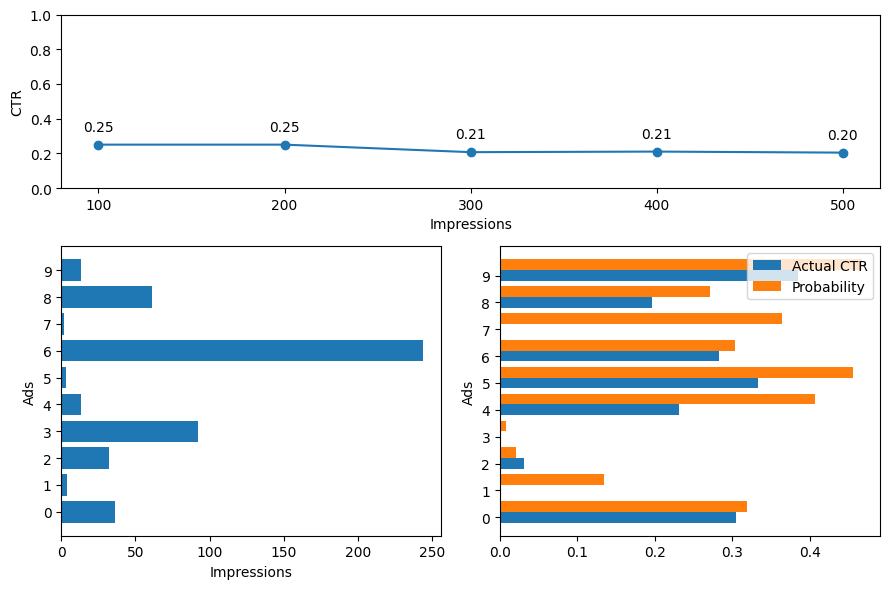

Episode: 350 Total Reward: 185 
Episode 350/1000 | Mean score: 4.04 | Epsilon: 0.03


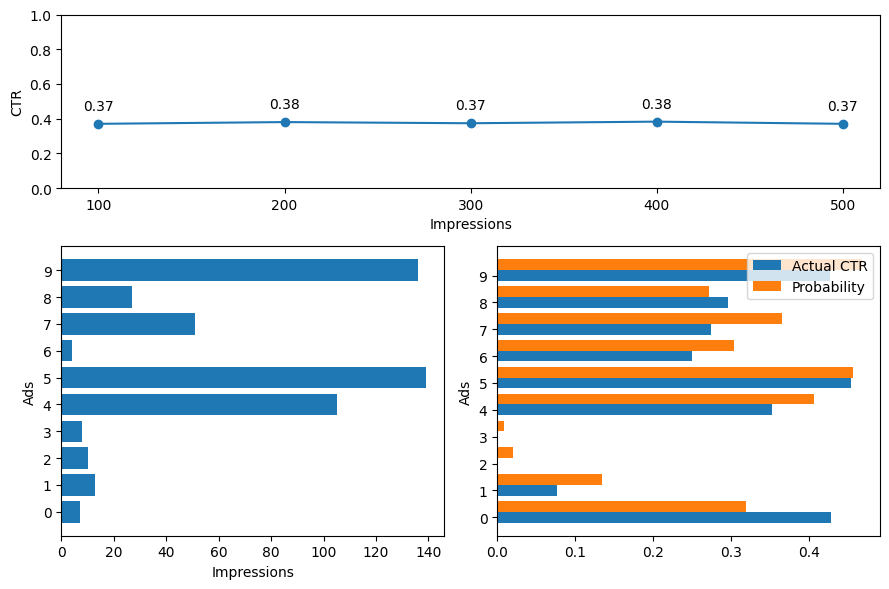

Episode: 400 Total Reward: 159 
Episode 400/1000 | Mean score: 3.52 | Epsilon: 0.03


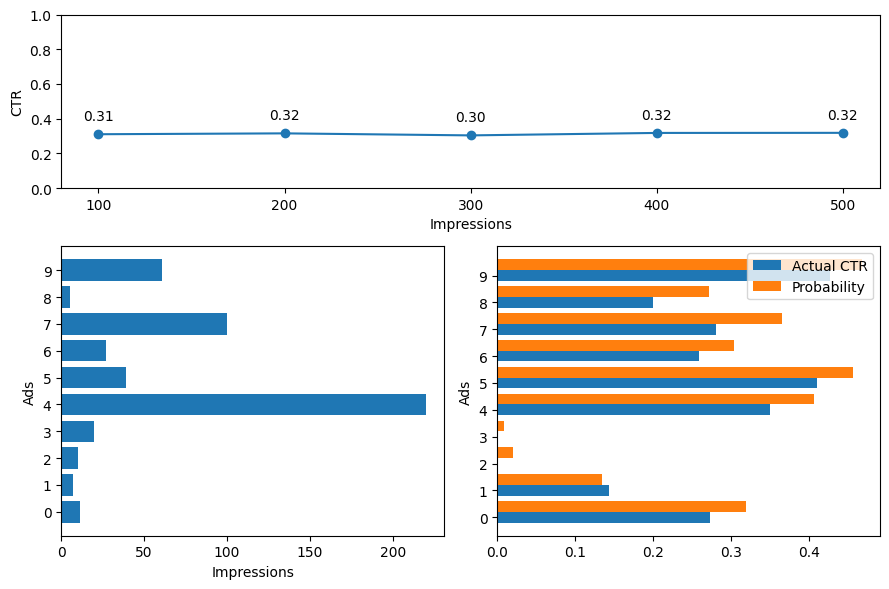

Episode: 450 Total Reward: 174 
Episode 450/1000 | Mean score: 3.74 | Epsilon: 0.03


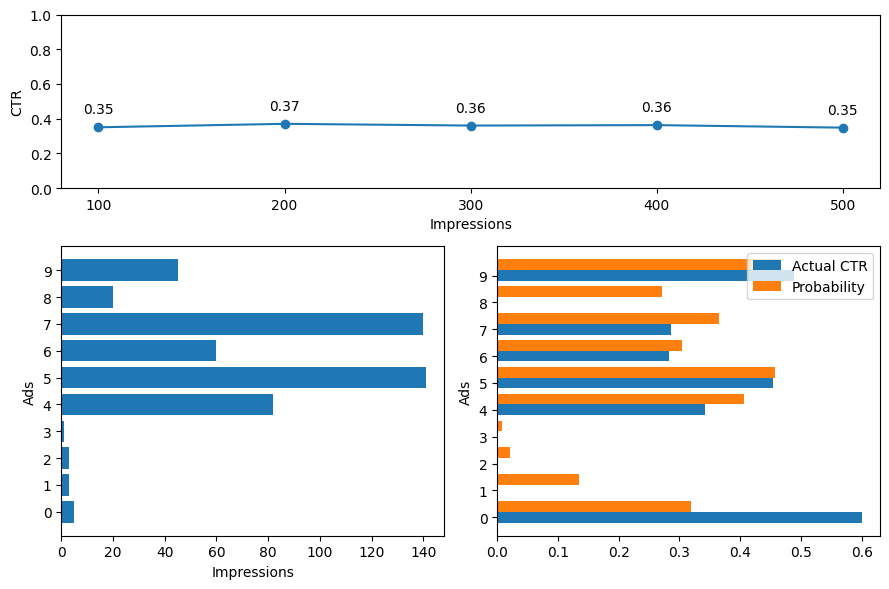

Episode: 500 Total Reward: 189 
Episode 500/1000 | Mean score: 4.18 | Epsilon: 0.03


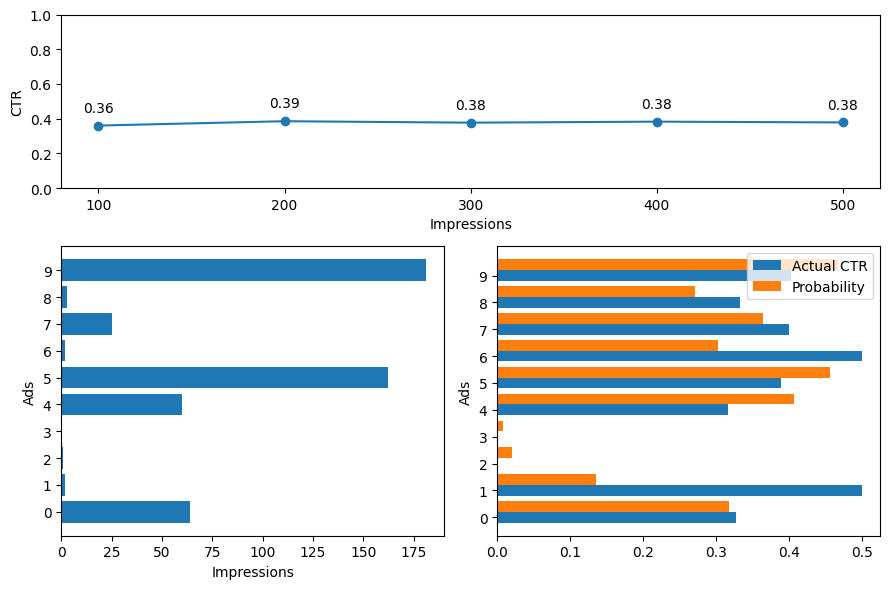

Episode: 550 Total Reward: 181 
Episode 550/1000 | Mean score: 3.96 | Epsilon: 0.03


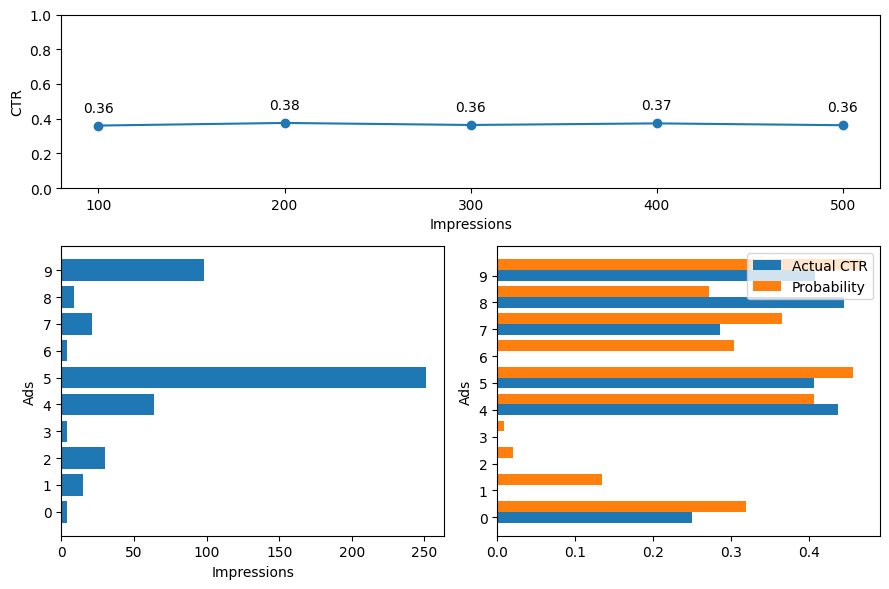

Episode: 600 Total Reward: 173 
Episode 600/1000 | Mean score: 3.82 | Epsilon: 0.03


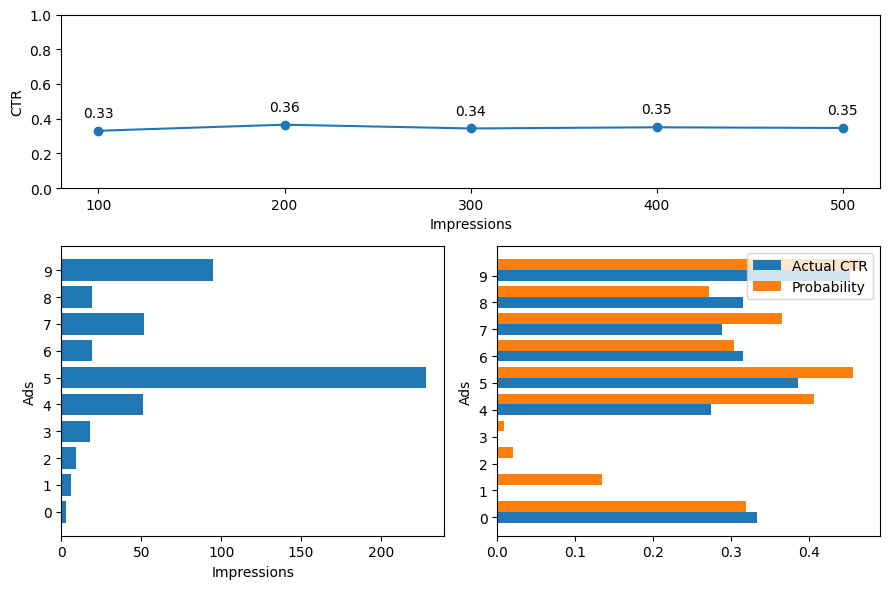

Episode: 650 Total Reward: 178 
Episode 650/1000 | Mean score: 3.92 | Epsilon: 0.03


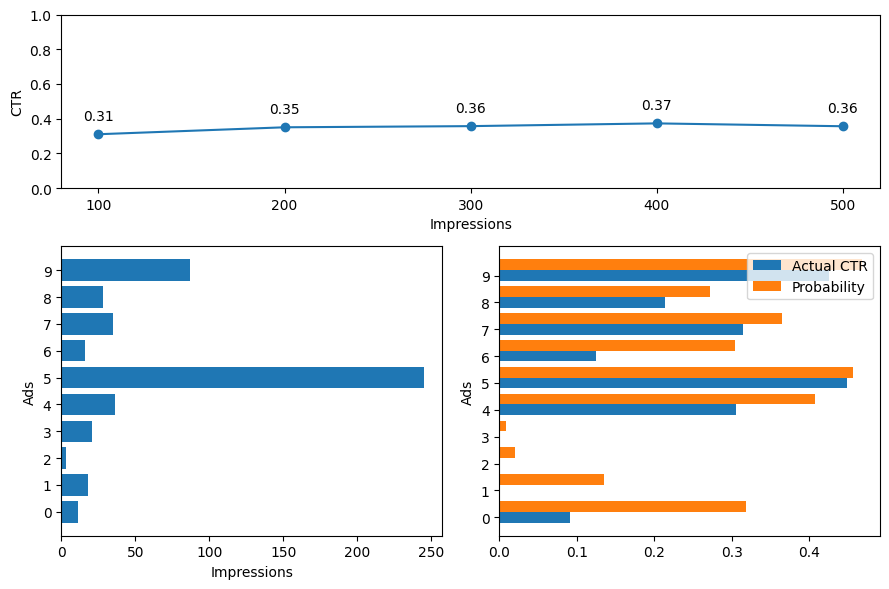

Episode: 700 Total Reward: 163 
Episode 700/1000 | Mean score: 3.66 | Epsilon: 0.03


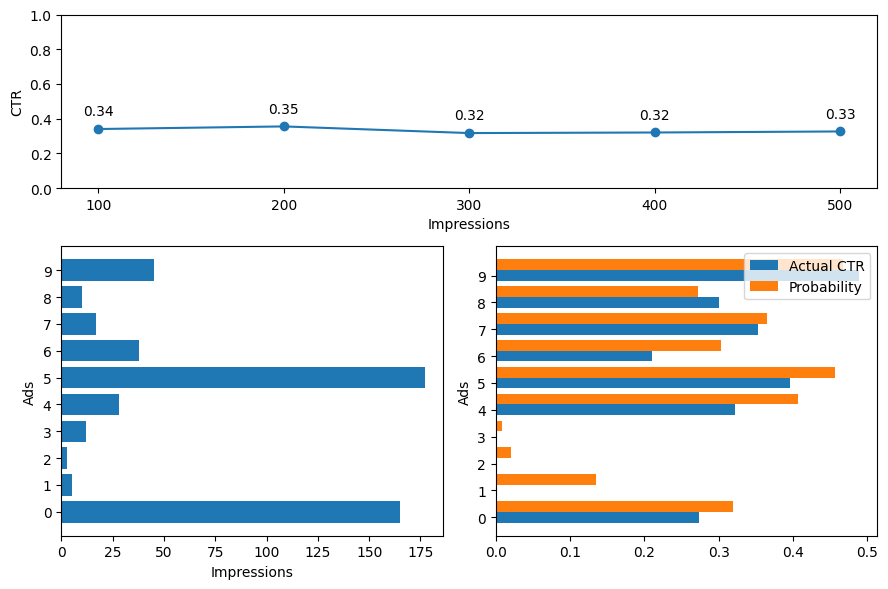

Episode: 750 Total Reward: 180 
Episode 750/1000 | Mean score: 4.00 | Epsilon: 0.03


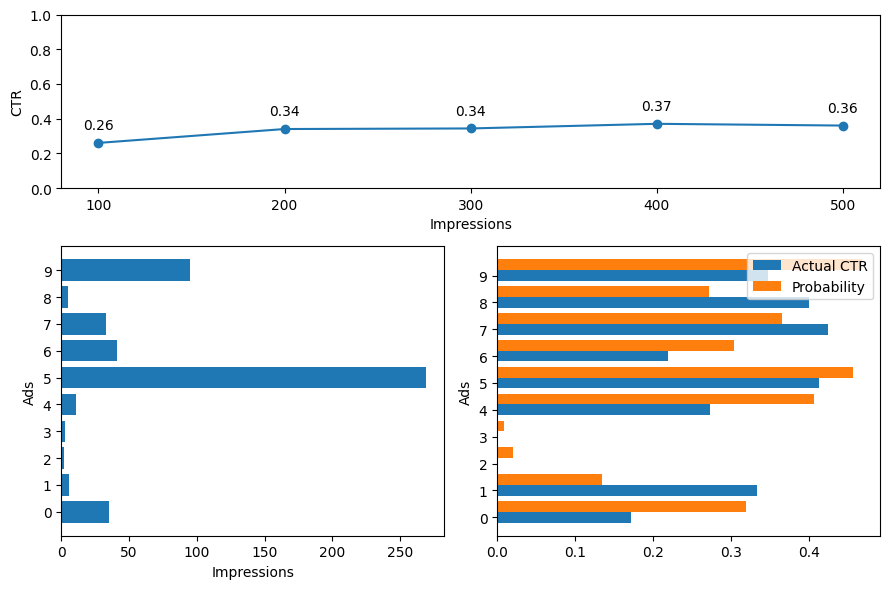

Episode: 800 Total Reward: 177 
Episode 800/1000 | Mean score: 3.96 | Epsilon: 0.03


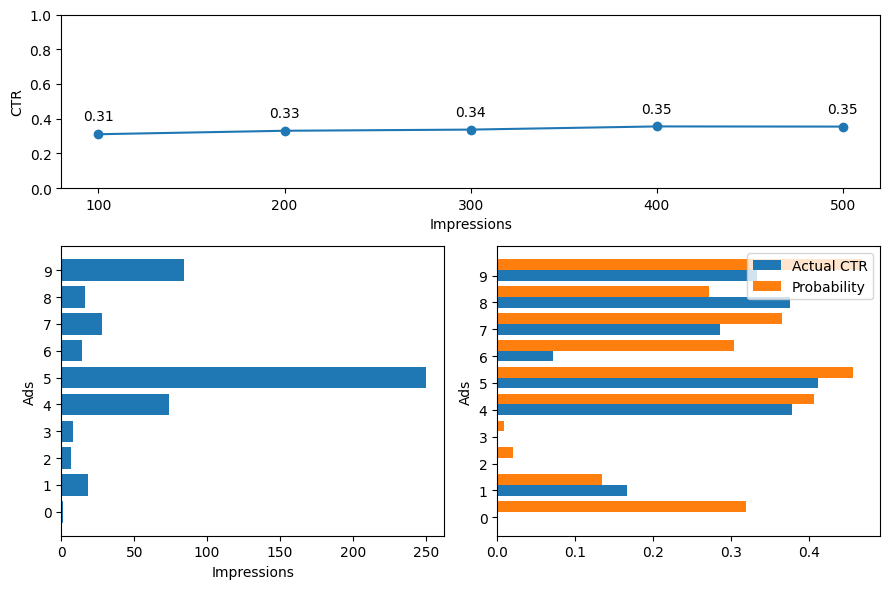

Episode: 850 Total Reward: 172 
Episode 850/1000 | Mean score: 3.82 | Epsilon: 0.03


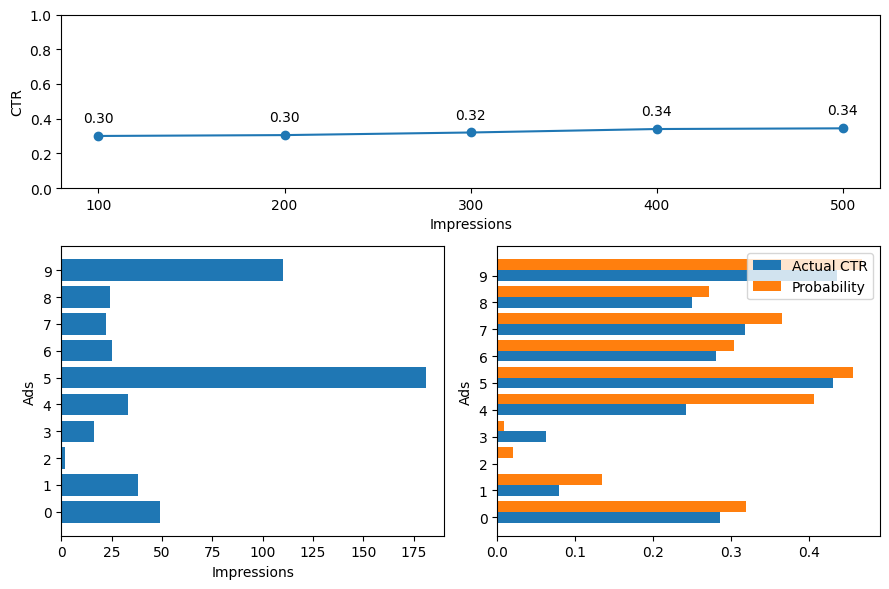

Episode: 900 Total Reward: 172 
Episode 900/1000 | Mean score: 3.78 | Epsilon: 0.03


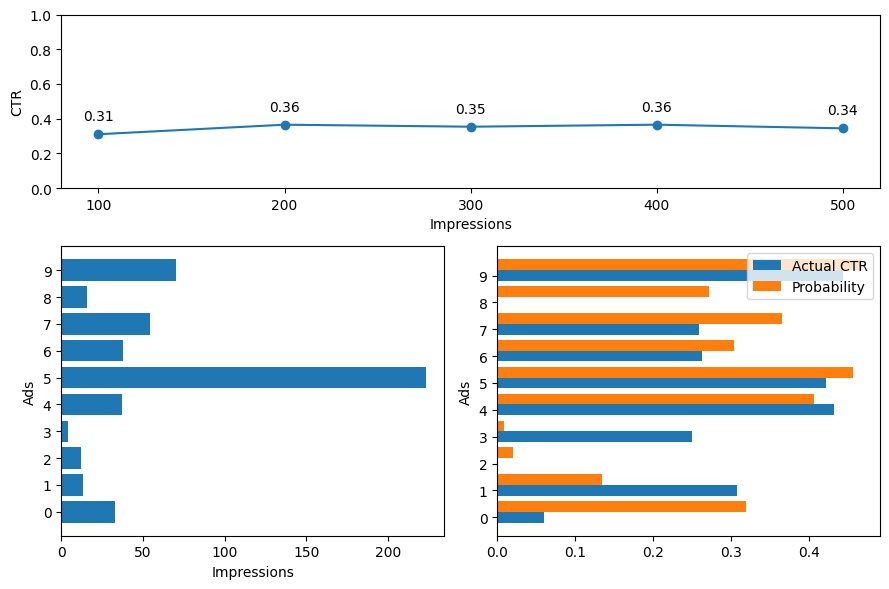

Episode: 950 Total Reward: 175 
Episode 950/1000 | Mean score: 3.86 | Epsilon: 0.03


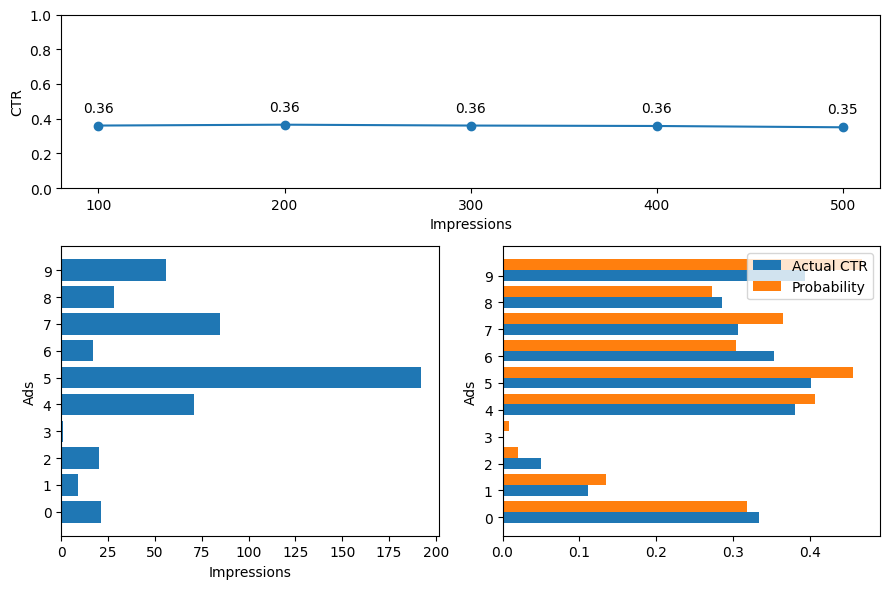

In [ ]:
import gym
import numpy as np
from collections import deque

# Environment parameters
NUM_AD_SLOTS = 10
NUM_ADS = 20
BUDGET = 1000

# DQN agent parameters
N_STATES = NUM_AD_SLOTS + NUM_ADS
N_ACTIONS = NUM_AD_SLOTS
BUFFER_SIZE = 10000
BATCH_SIZE = 128
GAMMA = 0.99
EPSILON = 1.0
EPSILON_MIN = 0.03
EPSILON_DECAY = 0.9999

env = AdServerEnv(num_ads=10, time_series_frequency = 100)

# Create environment and DQN agent
agent = DQNAgent(env=env, buffer_size=BUFFER_SIZE,
                 batch_size=BATCH_SIZE, gamma=GAMMA, epsilon=EPSILON,
                 epsilon_min=EPSILON_MIN, epsilon_decay=EPSILON_DECAY)

# Training parameters
EPISODES = 1000
STEPS_PER_EPISODE = 500

scores = deque(maxlen=50)

rewards = []
ep = []
# Training loop
for episode in range(EPISODES):
    state =  env.reset(seed=0, options={"scenario_name"})
    total_reward = 0
    c=0
    for step in range(STEPS_PER_EPISODE):
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        agent.replay()
        agent.update_epsilon()
        ep.append(agent.epsilon)
        if c % 50 == 0:
          agent.target_train()
        c+=1
        total_reward += reward
        scores.append(reward)
        state = next_state
        if done:
            break
    rewards.append(total_reward)
    scores.append(total_reward)
    

    if episode % 50 ==0:
      print("Episode:", episode, "Total Reward:", total_reward, "")
      print(f'Episode {episode}/{EPISODES} | Mean score: {np.mean(scores):.2f} | Epsilon: {agent.epsilon:.2f}')
      env.render()

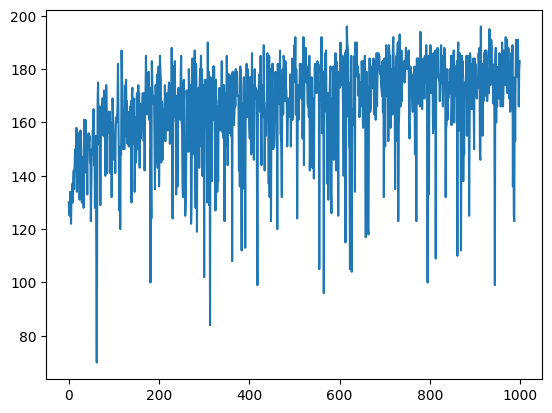

In [ ]:
plt.plot(rewards)
plt.show()

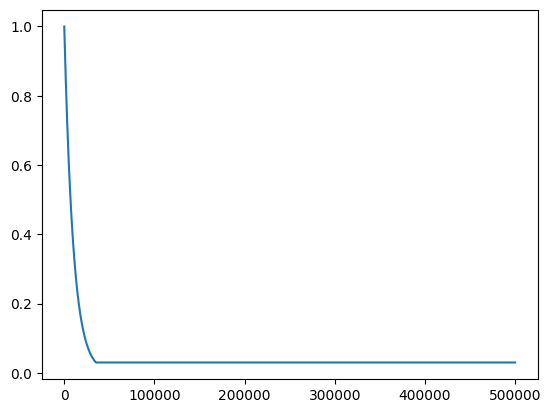

In [ ]:
plt.plot(ep)
plt.show()

In [ ]:
# Evaluate trained agent

rewards = []
# while not done:
for j in range(5):
  state = env.reset()
  done = False
  total_reward = 0
  for i in range(100):
      action = agent.act(state)
      state, reward, done, info = env.step(action)
      total_reward += reward
  print("Total Reward:", total_reward)
  rewards.append(total_reward)

Total Reward: 36
Total Reward: 35
Total Reward: 44
Total Reward: 42
Total Reward: 42


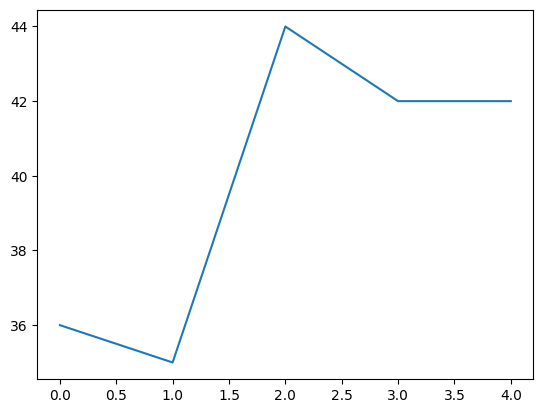

In [ ]:
plt.plot(rewards)
plt.show()